# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных
    - RowNumber — индекс строки в данных
    - CustomerId — уникальный идентификатор клиента
    - Surname — фамилия
    - CreditScore — кредитный рейтинг
    - Geography — страна проживания
    - Gender — пол
    - Age — возраст
    - Tenure — количество недвижимости у клиента
    - Balance — баланс на счёте
    - NumOfProducts — количество продуктов банка, используемых клиентом
    - HasCrCard — наличие кредитной карты
    - IsActiveMember — активность клиента
    - EstimatedSalary — предполагаемая зарплата
#### Целевой признак
    - Exited — факт ухода клиента

# 1. Подготовка данных

In [5]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score

In [7]:
clients.shape

(10000, 14)

In [8]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


#### Замена названий столбцов (приведение к нижнему змеиному регистру)

In [9]:
columns = []
# Получаем список названий колонок и приводим их к нижнему змеиному_регистру
for column in clients.columns.values:
    columns.append(re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower())
# Присваиваем датасету новые названия в нижнем регистре
clients.columns = columns

In [10]:
# Удаляем столбцы с данными, излишними для обучения модели.
clients.drop(['row_number', 'customer_id', 'surname'], axis=1,inplace=True)

In [11]:
clients.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [12]:
clients.tenure = clients.tenure.fillna(0.0)

In [13]:
clients.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [14]:
clients.loc[:, 'gender'] = (clients.gender == 'Male').astype('int')
clients.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
# Кодируем категориальные данные колонки География техникой One-Hot Encoding
ohe_enc = OneHotEncoder()
geo_ohe = ohe_enc.fit_transform(clients[['geography']]).toarray()
geo_ohe = pd.DataFrame(geo_ohe, columns=ohe_enc.categories_[0])
geo_ohe.head()

,France,Germany,Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [16]:
# Объединяем исходную таблицу с данными после кодирования техникой One-Hot Encoding в отдельную таблицу
clients_ohe = clients.join(geo_ohe)
# из полученной таблицы удаляем столбцы geography (т.к. она нам более не понадобится) и France - чтобы избежать дамми-ловушку.
clients_ohe = clients_ohe.drop(['geography', 'France'], axis=1)
clients_ohe.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,Germany,Spain
0,619,0,42,2.0,0.00,1,1,1,101348.88,1,0.0,0.0
1,608,0,41,1.0,83807.86,1,0,1,112542.58,0,0.0,1.0
2,502,0,42,8.0,159660.80,3,1,0,113931.57,1,0.0,0.0
3,699,0,39,1.0,0.00,2,0,0,93826.63,0,0.0,0.0
4,850,0,43,2.0,125510.82,1,1,1,79084.10,0,0.0,1.0


In [17]:
# Кодируем категориальные данные колонки География, в целочисленные признаки техникой OrdinalEncoding.
ordinal_enc = OrdinalEncoder()
geo_ordinal = ordinal_enc.fit_transform(clients[['geography']])
geo_ordinal = pd.DataFrame(geo_ordinal, columns=['geography'])
geo_ordinal.head()

,geography
0,0.0
1,2.0
2,0.0
3,0.0
4,2.0


In [18]:
# В исходной таблице меняем данные в столбце geography на целочисленные признаки техникой OrdinalEncoding
# Сохраняем получившийся датафрейм в отдельную таблицу
clients_ord = clients.copy()
clients_ord.loc[:, 'geography'] = geo_ordinal.loc[:, 'geography']
clients_ord.head(10)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,0.0,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0,43,2.0,125510.82,1,1,1,79084.10,0
5,645,2.0,1,44,8.0,113755.78,2,1,0,149756.71,1
6,822,0.0,1,50,7.0,0.00,2,1,1,10062.80,0
7,376,1.0,0,29,4.0,115046.74,4,1,0,119346.88,1
8,501,0.0,1,44,4.0,142051.07,2,0,1,74940.50,0
9,684,0.0,1,27,2.0,134603.88,1,1,1,71725.73,0


### Вывод:  
    - В нашем распоряжении 10_000 строк с данными.  
    - Столбцы 'row_number','customer_id','surname' были удалены из датасета, т.к. они являются лишними для обучения моделей, а также могут способствовать созданию множества лишних сущностей при кодировании.    
    - Названия колонок были приведены к нижнему змеиному регистру для лучшей читаемости и единообразия.  
    - Пропущенные значения были только в колонке "Количество недвижимости". Мы заполнили их нулями, посчитав что если клиенты не указали количество имеющейся недвижимости, то логично было бы предположить, что у них её нет  
    - Данные в колонке "Пол" привели к бинарной классификации  
    - Закодировали данные столбца "География" с помощью техник OrdinalEncoding и One-Hot Encoding.    
    - Данные полученные кодированием разными техниками объединяем с исходными данными в двух новых таблицах: clients_ord для данных кодированных техникой OrdinalEncoding и clients_ohe для данных кодированных техникой One-Hot Encoding.

# 2. Исследование задачи

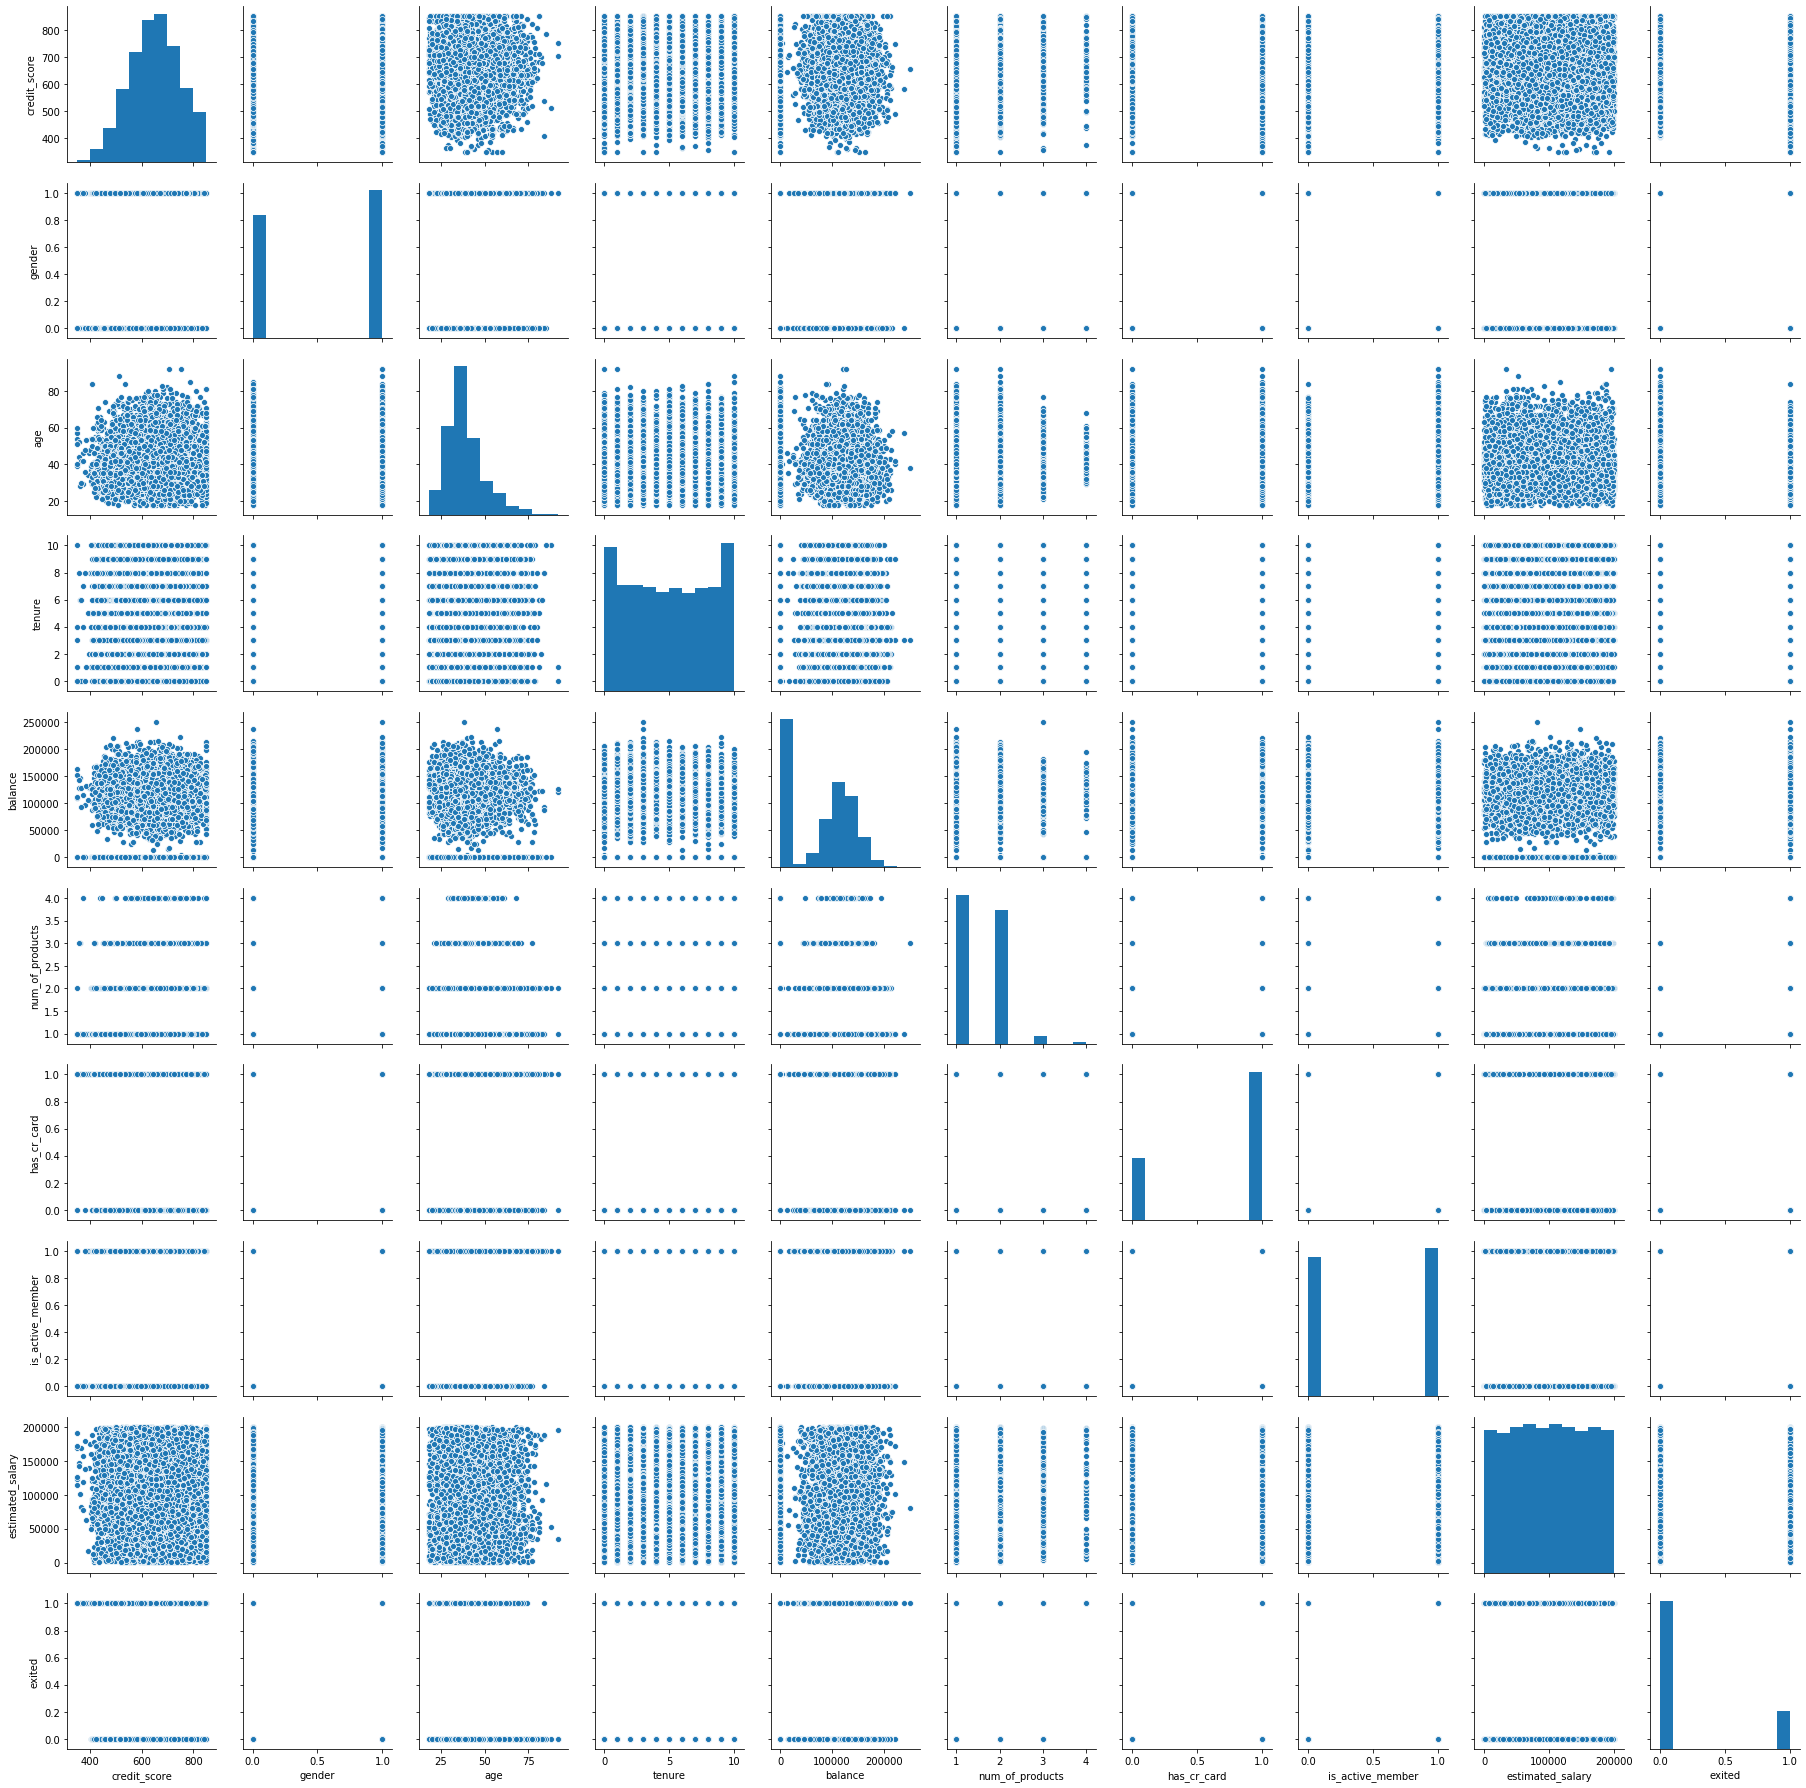

In [19]:
sns.pairplot(clients)

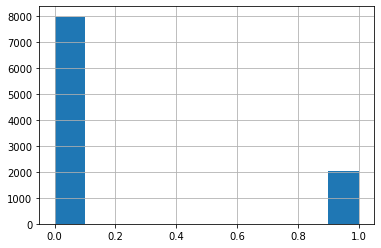

In [20]:
clients.exited.hist()

In [21]:
clients.exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

### Вывод:  
    - Значительный перевес: данных с exited=0 больше чем с exited=1 почти в 4 раза  
    - Большое количество клиентов с балансом равным 0;
    - Распределение кредитного рейтинга выглядит практически симметричным.  
    - Уровень предполагаемой зарплаты равномерно распределен.

# 3. Борьба с дисбалансом

In [23]:
# Выделяем признаки и цели из набора данных кодированных техникой OrdinalEncoding
ord_X = clients_ord.drop('exited', axis=1)
ord_Y = clients_ord.exited

In [24]:
# Выделяем признаки и цели из набора данных кодированных техникой One-Hot Encoding
ohe_X = clients_ohe.drop('exited', axis=1)
ohe_Y = clients_ohe.exited

In [25]:
# Делим выборку с данными кодированными техникой OrdinalEncoding
ord_X_train, ord_X_valid, ord_Y_train, ord_Y_valid = train_test_split(ord_X, ord_Y, test_size=0.2, random_state=12345)
ord_X_valid, ord_X_test, ord_Y_valid, ord_Y_test = train_test_split(ord_X_valid, ord_Y_valid, test_size=0.5, random_state=12345)

In [26]:
# Делим выборку с данными кодированными техникой One-Hot Encoding
ohe_X_train, ohe_X_valid, ohe_Y_train, ohe_Y_valid = train_test_split(ohe_X, ohe_Y, test_size=0.2, random_state=12345)
ohe_X_valid, ohe_X_test, ohe_Y_valid, ohe_Y_test = train_test_split(ohe_X_valid, ohe_Y_valid, test_size=0.5, random_state=12345)

In [27]:
# Из обучающей выборки OrdinalEncoding выделяем все данные с классом 0
ord_ex_0 = ord_X.loc[ord_Y_train[ord_Y_train==0].index]
ord_ex_0.shape

(6390, 10)

In [28]:
# Из обучающей выборки OrdinalEncoding выделяем все данные с классом 1
ord_ex_1 = ord_X.loc[ord_Y_train[ord_Y_train!=0].index]
ord_ex_1.shape

(1610, 10)

In [29]:
# Вычисляем разницу между классами в обучающей выборке OrdinalEncoding
difference = ord_ex_0.shape[0] - ord_ex_1.shape[0]
difference

4780

In [30]:
# Апсемплим тренировочную выборку OrdinalEncoding до одинакового количества в классах

# Копируем признаки с классом 1
x_upsample = ord_ex_1.sample(difference, replace=True)
# Заполняем цели единицами
y_upsample = np.repeat(1, difference)
# Конкатенируем обучающие признаки и цели с данными апсемпла
ord_X_upsampling_train = pd.concat([ord_X_train, x_upsample])
ord_Y_upsampling_train = np.hstack((ord_Y_train.values, y_upsample))
ord_X_upsampling_train.shape, ord_Y_upsampling_train.shape

((12780, 10), (12780,))

In [31]:
# Даунсемплим тренировочную выборку OrdinalEncoding до одинакового количества в классах

# Копируем признаки с классом 0
x_downsample = ord_ex_0.sample(ord_ex_1.shape[0])
# Заполняем цели нулями
y_downsample = np.repeat(0, ord_ex_1.shape[0])
# Конкатенируем обучающие признаки и цели с данными апсемпла
ord_X_downsampling_train = pd.concat([ord_ex_1, x_downsample])
ord_Y_downsampling_train = np.hstack((y_downsample, ord_Y_train[ord_Y_train!=0].values))
ord_X_downsampling_train.shape, ord_Y_downsampling_train.shape

((3220, 10), (3220,))

In [32]:
# Из обучающей выборки One-Hot Encoding выделяем все данные с классом 0
ohe_ex_0 = ohe_X.loc[ohe_Y_train[ohe_Y_train==0].index]
# Из обучающей выборки One-Hot Encoding выделяем все данные с классом 1
ohe_ex_1 = ohe_X.loc[ohe_Y_train[ohe_Y_train!=0].index]
ohe_ex_1.shape, ohe_ex_0.shape

((1610, 11), (6390, 11))

In [33]:
# Апсемплим тренировочную выборку One-Hot Encoding до одинакового количества в классах

# Копируем признаки с классом 1
ohe_x_upsample = ohe_ex_1.sample(difference, replace=True)
# Заполняем цели единицами
ohe_y_upsample = np.repeat(1, difference)
# Конкатенируем обучающие признаки и цели с данными апсемпла
ohe_X_upsampling_train = pd.concat([ohe_X_train, ohe_x_upsample])
ohe_Y_upsampling_train = np.hstack((ohe_Y_train.values, ohe_y_upsample))
ohe_X_upsampling_train.shape, ohe_Y_upsampling_train.shape

((12780, 11), (12780,))

In [34]:
# Даунсемплим тренировочную выборку One-Hot Encoding до одинакового количества в классах

# Копируем признаки с классом 0
ohe_x_downsample = ohe_ex_0.sample(ohe_ex_1.shape[0])
# Заполняем цели нулями
ohe_y_downsample = np.repeat(0, ohe_ex_1.shape[0])
# Конкатенируем обучающие признаки и цели с данными апсемпла
ohe_X_downsampling_train = pd.concat([ohe_ex_1, ohe_x_downsample])
ohe_Y_downsampling_train = np.hstack((ohe_Y_train[ord_Y_train!=0].values, ohe_y_downsample))
ohe_X_downsampling_train.shape, ohe_Y_downsampling_train.shape

((3220, 11), (3220,))

#### Вывод:  
___
    - Были выделены признаки и цели из наборов данных кодированных техниками OrdinalEncoding и One-Hot Encoding  
    - Наборы обучающих данных были сбалансированы техниками Upsampling и Downsampling.  
    - Для обучения моделей были подготовлены 4 набора тренировочных данных - Upsampling и Downsampling выборки с данными кодированными OrdinalEncoding и One-Hot Encoding

# 4. Тестирование модели

In [35]:
# Исследуем Логистическую регрессию с Downsample OrdinalEncoding данными
logres = LogisticRegression()
logres.fit(ord_X_downsampling_train, ord_Y_downsampling_train)
logres_predict = logres.predict(ord_X_valid)
logres_accuracy_score = accuracy_score(ord_Y_valid, logres_predict)
logres_f1_score = f1_score(ord_Y_valid, logres_predict)
logres_probabilities_valid = logres.predict_proba(ord_X_valid)
logres_probabilities_one_valid = logres_probabilities_valid[:, 1]
logres_auc_roc = roc_auc_score(ord_Y_valid, logres_probabilities_one_valid)
f'LogisticRegression Downsample OrdinalEncoding. Accuracy Score = {logres_accuracy_score}, F1_score = {logres_f1_score}, Auc_Roc={logres_auc_roc}'

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'LogisticRegression Downsample OrdinalEncoding. Accuracy Score = 0.37, F1_score = 0.18814432989690721, Auc_Roc=0.3015799283154122'

In [36]:
# Исследуем Логистическую регрессию с Upsample OrdinalEncoding данными
logres = LogisticRegression()
logres.fit(ord_X_upsampling_train, ord_Y_upsampling_train)
logres_predict = logres.predict(ord_X_valid)
logres_accuracy_score = accuracy_score(ord_Y_valid, logres_predict)
logres_f1_score = f1_score(ord_Y_valid, logres_predict)
logres_probabilities_valid = logres.predict_proba(ord_X_valid)
logres_probabilities_one_valid = logres_probabilities_valid[:, 1]
logres_auc_roc = roc_auc_score(ord_Y_valid, logres_probabilities_one_valid)
f'LogisticRegression Upsample OrdinalEncoding. Accuracy Score = {logres_accuracy_score}, F1_score = {logres_f1_score}, Auc_Roc={logres_auc_roc}'

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'LogisticRegression Upsample OrdinalEncoding. Accuracy Score = 0.631, F1_score = 0.4533333333333334, Auc_Roc=0.6985405017921147'

In [37]:
# Исследуем Логистическую регрессию с Upsample One-Hot Encoding данными
logres = LogisticRegression()
logres.fit(ohe_X_upsampling_train, ohe_Y_upsampling_train)
logres_predict = logres.predict(ohe_X_valid)
logres_accuracy_score = accuracy_score(ohe_Y_valid, logres_predict)
logres_f1_score = f1_score(ohe_Y_valid, logres_predict)
logres_probabilities_valid = logres.predict_proba(ohe_X_valid)
logres_probabilities_one_valid = logres_probabilities_valid[:, 1]
logres_auc_roc = roc_auc_score(ohe_Y_valid, logres_probabilities_one_valid)
f'LogisticRegression Upsample One-Hot Encoding. Accuracy Score = {logres_accuracy_score}, F1_score = {logres_f1_score}, Auc_Roc={logres_auc_roc}'

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'LogisticRegression Upsample One-Hot Encoding. Accuracy Score = 0.633, F1_score = 0.4497751124437781, Auc_Roc=0.6970437275985664'

In [38]:
# Исследуем Логистическую регрессию с Downsample One-Hot Encoding данными
logres = LogisticRegression()
logres.fit(ohe_X_downsampling_train, ohe_Y_downsampling_train)
logres_predict = logres.predict(ohe_X_valid)
logres_accuracy_score = accuracy_score(ohe_Y_valid, logres_predict)
logres_f1_score = f1_score(ohe_Y_valid, logres_predict)
logres_probabilities_valid = logres.predict_proba(ohe_X_valid)
logres_probabilities_one_valid = logres_probabilities_valid[:, 1]
logres_auc_roc = roc_auc_score(ohe_Y_valid, logres_probabilities_one_valid)
f'LogisticRegression Downsample One-Hot Encoding. Accuracy Score = {logres_accuracy_score}, F1_score = {logres_f1_score}, Auc_Roc={logres_auc_roc}'

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'LogisticRegression Downsample One-Hot Encoding. Accuracy Score = 0.632, F1_score = 0.4507462686567164, Auc_Roc=0.6958967741935483'

In [39]:
# DecisionTreeClassifier с Upsample One-Hot Encoding данными
for i in range(1, 10):
    dtc_model = DecisionTreeClassifier(max_depth=i, random_state=12345)
    dtc_model.fit(ohe_X_upsampling_train, ohe_Y_upsampling_train)
    dtc_valid_predictions = dtc_model.predict(ohe_X_valid)
    dtc_accuracy = accuracy_score(ohe_Y_valid, dtc_valid_predictions)
    dtc_f1_score = f1_score(ohe_Y_valid, dtc_valid_predictions)
    dtc_probabilities_valid = dtc_model.predict_proba(ohe_X_valid)
    dtc_probabilities_one_valid = dtc_probabilities_valid[:, 1]
    dtc_auc_roc = roc_auc_score(ohe_Y_valid, dtc_probabilities_one_valid)
    print(f"Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = {i}; accuracy = {dtc_accuracy}, F1={dtc_f1_score}, Auc_roc={dtc_auc_roc}")

Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = 1; accuracy = 0.714, F1=0.5017421602787456, Auc_roc=0.6877419354838711
Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = 2; accuracy = 0.727, F1=0.5380710659898477, Auc_roc=0.7566537634408602
Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = 3; accuracy = 0.727, F1=0.5380710659898477, Auc_roc=0.8055225806451612
Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = 4; accuracy = 0.777, F1=0.6135181975736568, Auc_roc=0.8380587813620072
Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = 5; accuracy = 0.743, F1=0.5861513687600644, Auc_roc=0.8478881720430107
Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = 6; accuracy = 0.788, F1=0.6200716845878135, Auc_roc=0.8430050179211469
Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = 7; accuracy = 0.779, F1=0.6088495575221239, Auc_roc=0.83311541218638
Upsample One-Hot Encoding DecisionTreeClassifier. max_depth = 8; accura

In [40]:
# DecisionTreeClassifier с Downsample One-Hot Encoding данными
for i in range(1, 10):
    dtc_model = DecisionTreeClassifier(max_depth=i, random_state=12345)
    dtc_model.fit(ohe_X_downsampling_train, ohe_Y_downsampling_train)
    dtc_valid_predictions = dtc_model.predict(ohe_X_valid)
    dtc_accuracy = accuracy_score(ohe_Y_valid, dtc_valid_predictions)
    dtc_f1_score = f1_score(ohe_Y_valid, dtc_valid_predictions)
    dtc_probabilities_valid = dtc_model.predict_proba(ohe_X_valid)
    dtc_probabilities_one_valid = dtc_probabilities_valid[:, 1]
    dtc_auc_roc = roc_auc_score(ohe_Y_valid, dtc_probabilities_one_valid)
    print(f"Downsample One-Hot Encoding DecisionTreeClassifier. max_depth = {i}; accuracy = {dtc_accuracy}, F1={dtc_f1_score}, Auc_roc={dtc_auc_roc}")

Downsample One-Hot Encoding DecisionTreeClassifier. max_depth = 1; accuracy = 0.714, F1=0.5017421602787456, Auc_roc=0.6877419354838711
Downsample One-Hot Encoding DecisionTreeClassifier. max_depth = 2; accuracy = 0.727, F1=0.5380710659898477, Auc_roc=0.7566537634408602
Downsample One-Hot Encoding DecisionTreeClassifier. max_depth = 3; accuracy = 0.727, F1=0.5380710659898477, Auc_roc=0.8052444444444444
Downsample One-Hot Encoding DecisionTreeClassifier. max_depth = 4; accuracy = 0.799, F1=0.6325411334552101, Auc_roc=0.8471885304659498
Downsample One-Hot Encoding DecisionTreeClassifier. max_depth = 5; accuracy = 0.755, F1=0.6016260162601627, Auc_roc=0.8554322580645161
Downsample One-Hot Encoding DecisionTreeClassifier. max_depth = 6; accuracy = 0.769, F1=0.6104553119730185, Auc_roc=0.8446422939068099
Downsample One-Hot Encoding DecisionTreeClassifier. max_depth = 7; accuracy = 0.724, F1=0.5619047619047619, Auc_roc=0.8244473118279569
Downsample One-Hot Encoding DecisionTreeClassifier. max

In [41]:
# DecisionTreeClassifier с Downsample OrdinalEncoding данными
for i in range(1, 10):
    dtc_model = DecisionTreeClassifier(max_depth=i, random_state=12345)
    dtc_model.fit(ord_X_downsampling_train, ord_Y_downsampling_train)
    dtc_valid_predictions = dtc_model.predict(ord_X_valid)
    dtc_accuracy = accuracy_score(ord_Y_valid, dtc_valid_predictions)
    dtc_f1_score = f1_score(ord_Y_valid, dtc_valid_predictions)
    dtc_probabilities_valid = dtc_model.predict_proba(ord_X_valid)
    dtc_probabilities_one_valid = dtc_probabilities_valid[:, 1]
    dtc_auc_roc = roc_auc_score(ord_Y_valid, dtc_probabilities_one_valid)
    print(f"Downsample OrdinalEncoding DecisionTreeClassifier. max_depth = {i}; accuracy = {dtc_accuracy}, F1={dtc_f1_score}, Auc_roc={dtc_auc_roc}")

Downsample OrdinalEncoding DecisionTreeClassifier. max_depth = 1; accuracy = 0.33, F1=0.14758269720101783, Auc_roc=0.3043727598566308
Downsample OrdinalEncoding DecisionTreeClassifier. max_depth = 2; accuracy = 0.318, F1=0.116580310880829, Auc_roc=0.22514121863799286
Downsample OrdinalEncoding DecisionTreeClassifier. max_depth = 3; accuracy = 0.318, F1=0.116580310880829, Auc_roc=0.18670107526881727
Downsample OrdinalEncoding DecisionTreeClassifier. max_depth = 4; accuracy = 0.232, F1=0.12328767123287672, Auc_roc=0.16629677419354838
Downsample OrdinalEncoding DecisionTreeClassifier. max_depth = 5; accuracy = 0.198, F1=0.1282608695652174, Auc_roc=0.1586179211469534
Downsample OrdinalEncoding DecisionTreeClassifier. max_depth = 6; accuracy = 0.271, F1=0.10989010989010989, Auc_roc=0.15582222222222222
Downsample OrdinalEncoding DecisionTreeClassifier. max_depth = 7; accuracy = 0.265, F1=0.10256410256410257, Auc_roc=0.15859498207885303
Downsample OrdinalEncoding DecisionTreeClassifier. max_d

In [42]:
# DecisionTreeClassifier с Upsample OrdinalEncoding данными
for i in range(1, 10):
    dtc_model = DecisionTreeClassifier(max_depth=i, random_state=12345)
    dtc_model.fit(ord_X_upsampling_train, ord_Y_upsampling_train)
    dtc_valid_predictions = dtc_model.predict(ord_X_valid)
    dtc_accuracy = accuracy_score(ord_Y_valid, dtc_valid_predictions)
    dtc_f1_score = f1_score(ord_Y_valid, dtc_valid_predictions)
    dtc_probabilities_valid = dtc_model.predict_proba(ord_X_valid)
    dtc_probabilities_one_valid = dtc_probabilities_valid[:, 1]
    dtc_auc_roc = roc_auc_score(ord_Y_valid, dtc_probabilities_one_valid)
    print(f"Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = {i}; accuracy = {dtc_accuracy}, F1={dtc_f1_score}, Auc_roc={dtc_auc_roc}")

Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = 1; accuracy = 0.714, F1=0.5017421602787456, Auc_roc=0.6877419354838711
Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = 2; accuracy = 0.727, F1=0.5380710659898477, Auc_roc=0.7566537634408602
Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = 3; accuracy = 0.727, F1=0.5380710659898477, Auc_roc=0.8047971326164874
Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = 4; accuracy = 0.797, F1=0.5964214711729622, Auc_roc=0.8308587813620072
Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = 5; accuracy = 0.768, F1=0.5886524822695036, Auc_roc=0.8414480286738352
Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = 6; accuracy = 0.77, F1=0.5818181818181818, Auc_roc=0.8321261648745519
Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = 7; accuracy = 0.727, F1=0.5396290050590219, Auc_roc=0.7954035842293906
Upsample OrdinalEncoding DecisionTreeClassifier. max_depth = 8; accuracy = 0.

In [43]:
# RandomForest с Upsample OrdinalEncoding данными
for i in range(1, 11):
    rf_model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=i)
    rf_model.fit(ord_X_upsampling_train, ord_Y_upsampling_train)
    rf_valid_predictions = rf_model.predict(ord_X_valid)
    score = accuracy_score( ord_Y_valid, rf_valid_predictions)
    rf_f1_score = f1_score(ord_Y_valid, rf_valid_predictions)
    rf_probabilities_valid = rf_model.predict_proba(ord_X_valid)
    rf_probabilities_one_valid = rf_probabilities_valid[:, 1]
    rf_auc_roc = roc_auc_score(ord_Y_valid, rf_probabilities_one_valid)
    print(f'Upsample OrdinalEncoding RandomForestClassifier, max_depth={i}, score={score}, F1={dtc_f1_score}, Auc_roc={dtc_auc_roc}')

Upsample OrdinalEncoding RandomForestClassifier, max_depth=1, score=0.736, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample OrdinalEncoding RandomForestClassifier, max_depth=2, score=0.755, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample OrdinalEncoding RandomForestClassifier, max_depth=3, score=0.769, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample OrdinalEncoding RandomForestClassifier, max_depth=4, score=0.775, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample OrdinalEncoding RandomForestClassifier, max_depth=5, score=0.781, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample OrdinalEncoding RandomForestClassifier, max_depth=6, score=0.783, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample OrdinalEncoding RandomForestClassifier, max_depth=7, score=0.793, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample OrdinalEncoding RandomForestClassifier, max_depth=8, score=0.801, F1=0.4973357015985791, Auc_roc=0.7459756272401433


In [44]:
# RandomForest с Downsample OrdinalEncoding данными
for i in range(1, 11):
    rf_model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=i)
    rf_model.fit(ord_X_downsampling_train, ord_Y_downsampling_train)
    rf_valid_predictions = rf_model.predict(ord_X_valid)
    score = accuracy_score( ord_Y_valid, rf_valid_predictions)
    rf_f1_score = f1_score(ord_Y_valid, rf_valid_predictions)
    rf_probabilities_valid = rf_model.predict_proba(ord_X_valid)
    rf_probabilities_one_valid = rf_probabilities_valid[:, 1]
    rf_auc_roc = roc_auc_score(ord_Y_valid, rf_probabilities_one_valid)
    print(f'Downsample OrdinalEncoding RandomForestClassifier, max_depth={i}, score={score}, F1={dtc_f1_score}, Auc_roc={dtc_auc_roc}')

Downsample OrdinalEncoding RandomForestClassifier, max_depth=1, score=0.281, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Downsample OrdinalEncoding RandomForestClassifier, max_depth=2, score=0.26, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Downsample OrdinalEncoding RandomForestClassifier, max_depth=3, score=0.251, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Downsample OrdinalEncoding RandomForestClassifier, max_depth=4, score=0.245, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Downsample OrdinalEncoding RandomForestClassifier, max_depth=5, score=0.223, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Downsample OrdinalEncoding RandomForestClassifier, max_depth=6, score=0.231, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Downsample OrdinalEncoding RandomForestClassifier, max_depth=7, score=0.224, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Downsample OrdinalEncoding RandomForestClassifier, max_depth=8, score=0.221, F1=0.4973357015985791, Auc_roc=0.74

In [45]:
# RandomForest с Upsample One-Hot Encoding данными
for i in range(1, 11):
    rf_model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=i)
    rf_model.fit(ohe_X_upsampling_train, ohe_Y_upsampling_train)
    rf_valid_predictions = rf_model.predict(ohe_X_valid)
    score = accuracy_score(ohe_Y_valid, rf_valid_predictions)
    rf_f1_score = f1_score(ohe_Y_valid, rf_valid_predictions)
    rf_probabilities_valid = rf_model.predict_proba(ohe_X_valid)
    rf_probabilities_one_valid = rf_probabilities_valid[:, 1]
    rf_auc_roc = roc_auc_score(ohe_Y_valid, rf_probabilities_one_valid)
    print(f'Upsample One-Hot Encoding RandomForestClassifier, max_depth={i}, score={score}, F1={dtc_f1_score}, Auc_roc={dtc_auc_roc}')

Upsample One-Hot Encoding RandomForestClassifier, max_depth=1, score=0.712, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample One-Hot Encoding RandomForestClassifier, max_depth=2, score=0.727, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample One-Hot Encoding RandomForestClassifier, max_depth=3, score=0.765, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample One-Hot Encoding RandomForestClassifier, max_depth=4, score=0.775, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample One-Hot Encoding RandomForestClassifier, max_depth=5, score=0.784, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample One-Hot Encoding RandomForestClassifier, max_depth=6, score=0.798, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample One-Hot Encoding RandomForestClassifier, max_depth=7, score=0.81, F1=0.4973357015985791, Auc_roc=0.7459756272401433
Upsample One-Hot Encoding RandomForestClassifier, max_depth=8, score=0.82, F1=0.4973357015985791, Auc_roc=0.74597562724

In [140]:
# RandomForest с Downsample One-Hot Encoding данными
for i in range(1, 11):
    rf_model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=i)
    rf_model.fit(ohe_X_downsampling_train, ohe_Y_downsampling_train)
    rf_valid_predictions = rf_model.predict(ohe_X_valid)
    score = accuracy_score(ohe_Y_valid, rf_valid_predictions)
    rf_f1_score = f1_score(ohe_Y_valid, rf_valid_predictions)
    rf_probabilities_valid = rf_model.predict_proba(ohe_X_valid)
    rf_probabilities_one_valid = rf_probabilities_valid[:, 1]
    rf_auc_roc = roc_auc_score(ohe_Y_valid, rf_probabilities_one_valid)
    print(f'Downsample One-Hot Encoding RandomForestClassifier, max_depth={i}, score={score}, F1={dtc_f1_score}, Auc_roc={dtc_auc_roc}')

Downsample One-Hot Encoding RandomForestClassifier, max_depth=1, score=0.707, F1=0.6307692307692307, Auc_roc=0.8154231389525507
Downsample One-Hot Encoding RandomForestClassifier, max_depth=2, score=0.744, F1=0.6307692307692307, Auc_roc=0.8154231389525507
Downsample One-Hot Encoding RandomForestClassifier, max_depth=3, score=0.765, F1=0.6307692307692307, Auc_roc=0.8154231389525507
Downsample One-Hot Encoding RandomForestClassifier, max_depth=4, score=0.78, F1=0.6307692307692307, Auc_roc=0.8154231389525507
Downsample One-Hot Encoding RandomForestClassifier, max_depth=5, score=0.78, F1=0.6307692307692307, Auc_roc=0.8154231389525507
Downsample One-Hot Encoding RandomForestClassifier, max_depth=6, score=0.785, F1=0.6307692307692307, Auc_roc=0.8154231389525507
Downsample One-Hot Encoding RandomForestClassifier, max_depth=7, score=0.78, F1=0.6307692307692307, Auc_roc=0.8154231389525507
Downsample One-Hot Encoding RandomForestClassifier, max_depth=8, score=0.783, F1=0.6307692307692307, Auc_ro

### Выбор модели:  
    - Наилучший результат показала модель RandomForestClassifier с параметрами n_estimators=100, максимальной глубиной обучения=9, обученная на увеличенной выборке с данными кодированными с помощью OrdinalEncoder.

In [145]:
model = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=12345)
model.fit(ord_X_upsampling_train, ord_Y_upsampling_train)
prediction = model.predict(ord_X_test)
score = accuracy_score(ord_Y_test, prediction)
rf_f1_score = f1_score(ord_Y_test, prediction)
probabilities_valid = model.predict_proba(ord_X_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(ord_Y_test, probabilities_one_valid)
print(f'Upsample OrdinalEncoding RandomForestClassifier,score={score}, F1={dtc_f1_score}, Auc_roc {dtc_auc_roc}')

Upsample OrdinalEncoding RandomForestClassifier,score=0.808, F1=0.6307692307692307, Auc_roc 0.8154231389525507


## Общий вывод:  
___
#### Была проведена предварительная подготовка данных:
    - Названия колонок приведены к общему и более читабельному виду;  
    - Удалены столбцы с данными избыточными для обучения моделей;  
    - Заполнены пропущенные данные;  
    - Данные в колонке "Пол" привели к бинарной классификации и целочисленному формату;    
    - Данные в столбце "География" были закодированы с помощью техник OrdinalEncoding и One-Hot Encoding. Полученные с помощью кодирования данные были помещены в разные датасеты, чтобы в процессе обучения модели выявить наиболее подходящую технику кодирования.  
#### Было проведено исследование задачи:  
    - Мы исследовали баланс классов;  
    - Выявили дисбаланс т.к. данных класса 0 было почти в 4 раза больше чем данных класса 1.  
#### Был учтён дисбаланс:  
    - Данные были разделены на тренировочную, валидационную и тестовую выборки.  
    - С помощью техник Апсемплинг и Даунсемплинг были созданы сбалансированные обучающие выборки с увеличенным количеством данных класса 1 и уменьшеным количеством данных класса 0, соответственно.  
#### Было проведено тестирование:  
    - В ходе обучения на тренировочных данных и проверки этого обучения на валидационных данных были рассмотрены модели логистической регрессии, дерева принятия решения и случайного леса.  
    - В результате рассмотрения моделей была выбрана модель с максимальными значениями Accuracy Score, F1-score и Auc_Roc - модель RandomForestClassifier с параметрами n_estimators=100, максимальной глубиной обучения=9, обученная на увеличенной выборке с данными кодированными с помощью OrdinalEncoder.